In [ ]:
# Install pyspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=45cc365213ee026852f9f4aebf50c894695ab61a5e38bce262eab90c8dd32637
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.ml.feature import IndexToString
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd

In [ ]:
# Initialize Spark session
spark = SparkSession.builder.appName("Car Classification").getOrCreate()

In [ ]:
# Load and concatenate CSV files
dfs = []
for file_name in ["car_evaluation_0.csv", "car_evaluation_1.csv", "car_evaluation_2.csv", "car_evaluation_3.csv"]:
    dfs.append(spark.read.csv(file_name, header=True, inferSchema=True))

data = dfs[0]
for df in dfs[1:]:
    data = data.union(df)

In [ ]:
data.printSchema()

root
 |-- buyPrice: string (nullable = true)
 |-- maintCost: string (nullable = true)
 |-- noDoors: string (nullable = true)
 |-- noPersons: string (nullable = true)
 |-- bootLuggage: string (nullable = true)
 |-- safety: string (nullable = true)
 |-- decision: string (nullable = true)



In [ ]:
data.show()

+--------+---------+-------+---------+-----------+------+--------+
|buyPrice|maintCost|noDoors|noPersons|bootLuggage|safety|decision|
+--------+---------+-------+---------+-----------+------+--------+
|   vhigh|    vhigh|      2|        2|      small|   med|   unacc|
|   vhigh|    vhigh|      2|        2|      small|  high|   unacc|
|   vhigh|    vhigh|      2|        2|        med|   low|   unacc|
|   vhigh|    vhigh|      2|        2|        med|   med|   unacc|
|   vhigh|    vhigh|      2|        2|        med|  high|   unacc|
|   vhigh|    vhigh|      2|        2|        big|   low|   unacc|
|   vhigh|    vhigh|      2|        2|        big|   med|   unacc|
|   vhigh|    vhigh|      2|        2|        big|  high|   unacc|
|   vhigh|    vhigh|      2|        4|      small|   low|   unacc|
|   vhigh|    vhigh|      2|        4|      small|   med|   unacc|
|   vhigh|    vhigh|      2|        4|      small|  high|   unacc|
|   vhigh|    vhigh|      2|        4|        med|   low|   un

In [ ]:
data.describe().show()

+-------+--------+---------+------------------+------------------+-----------+------+--------+
|summary|buyPrice|maintCost|           noDoors|         noPersons|bootLuggage|safety|decision|
+-------+--------+---------+------------------+------------------+-----------+------+--------+
|  count|    1727|     1727|              1727|              1727|       1727|  1727|    1727|
|   mean|    null|     null|3.0007722007722006| 3.000868809730669|       null|  null|    null|
| stddev|    null|     null|0.8166539469613201|1.0004343105525064|       null|  null|    null|
|    min|    high|     high|                 2|                 2|        big|  high|     acc|
|    max|   vhigh|    vhigh|             5more|              more|      small|   med|   vgood|
+-------+--------+---------+------------------+------------------+-----------+------+--------+



In [ ]:
for col_name in data.columns:
    print(f"{col_name}: {data.select(col_name).distinct().count()} unique values")

buyPrice: 4 unique values
maintCost: 4 unique values
noDoors: 4 unique values
noPersons: 3 unique values
bootLuggage: 3 unique values
safety: 3 unique values
decision: 4 unique values


In [ ]:
# Check for missing values in the dataset
for col_name in data.columns:
    print(f"{col_name}: {data.filter(col(col_name).isNull()).count()} missing values")

buyPrice: 0 missing values
maintCost: 0 missing values
noDoors: 0 missing values
noPersons: 0 missing values
bootLuggage: 0 missing values
safety: 0 missing values
decision: 0 missing values


+--------+-----+
|decision|count|
+--------+-----+
|   unacc| 1209|
|     acc|  384|
|   vgood|   65|
|    good|   69|
+--------+-----+



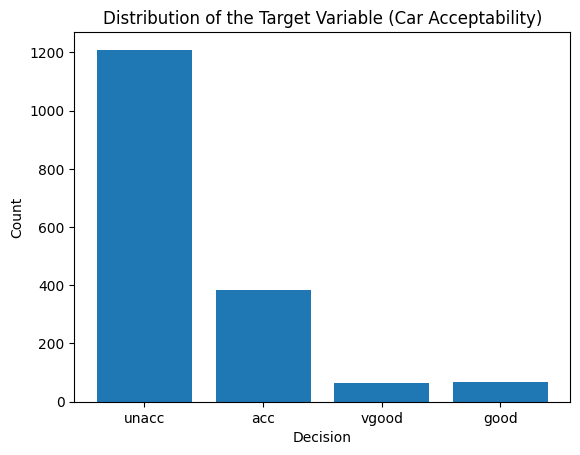

In [ ]:
# Calculate and display the target variable distribution in the Spark DataFrame
target_distribution = data.groupBy("decision").count()
target_distribution.show()

# Convert the Spark DataFrame with the target variable distribution to a Pandas DataFrame
target_distribution_pd = target_distribution.toPandas()

# Create a bar chart using Matplotlib
plt.bar(target_distribution_pd["decision"], target_distribution_pd["count"])
plt.xlabel("Decision")
plt.ylabel("Count")
plt.title("Distribution of the Target Variable (Car Acceptability)")
plt.show()

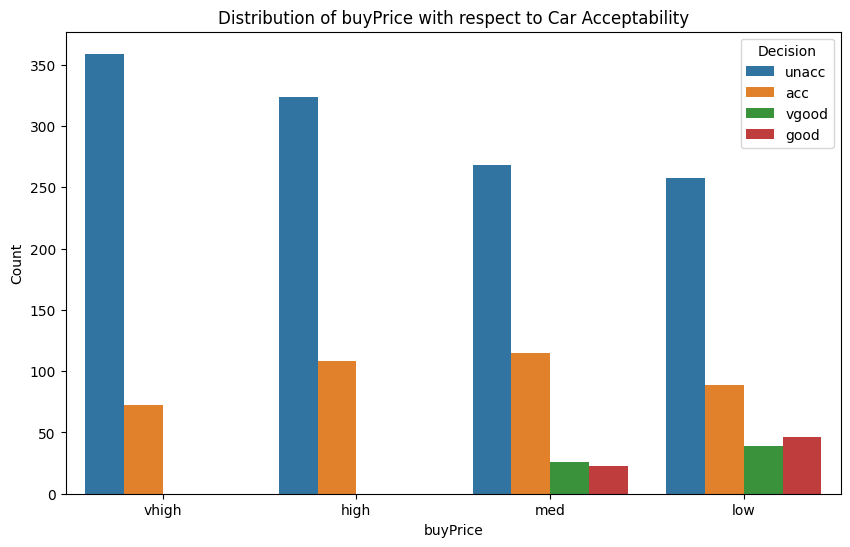

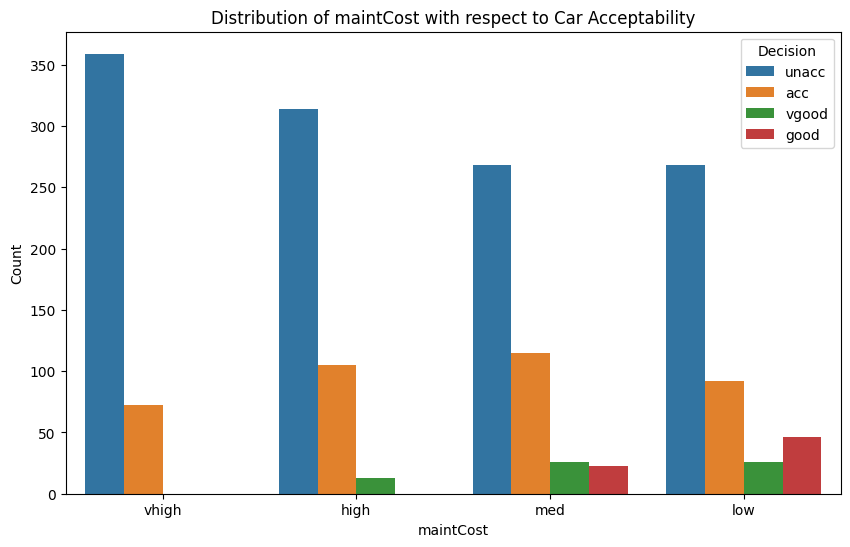

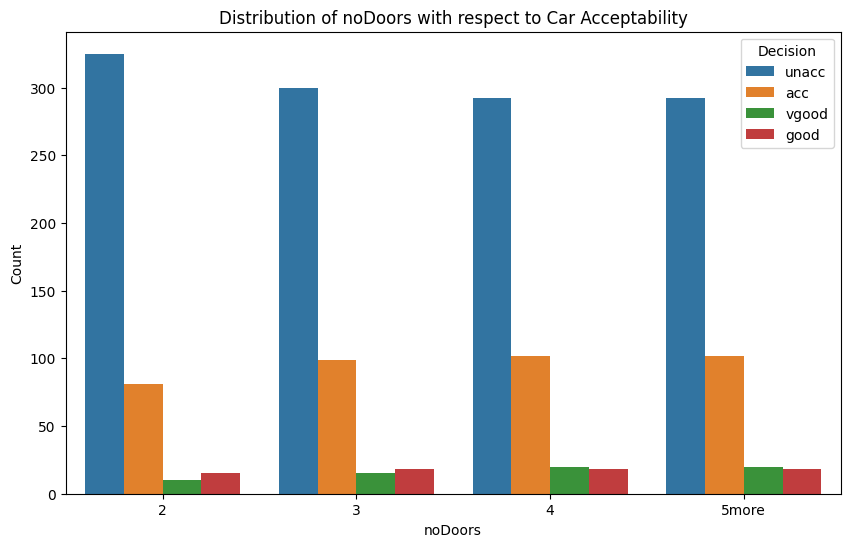

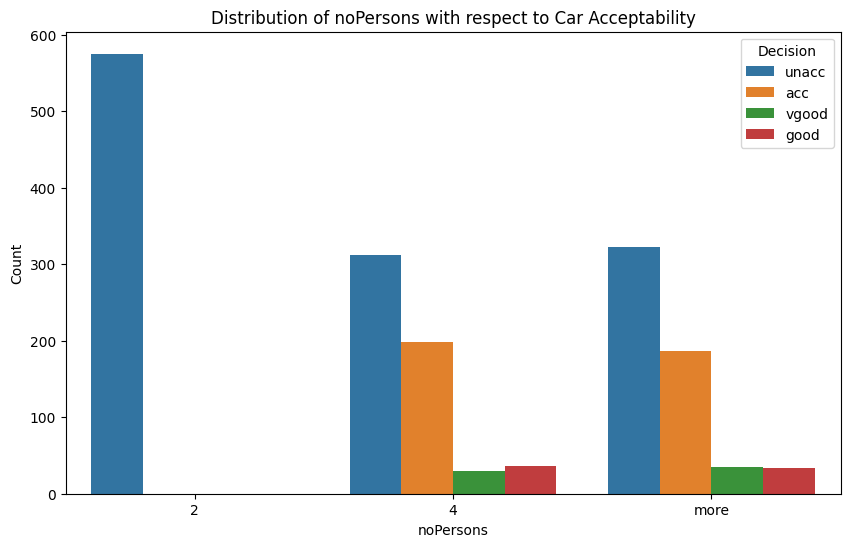

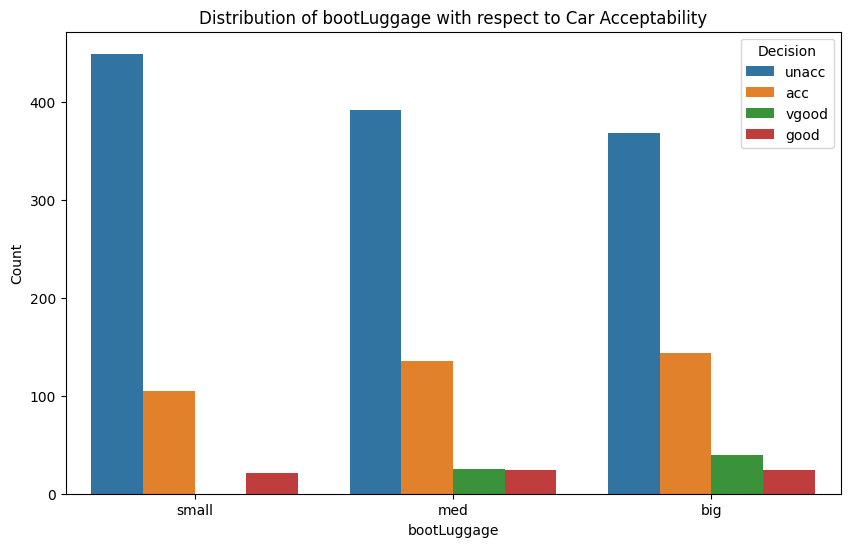

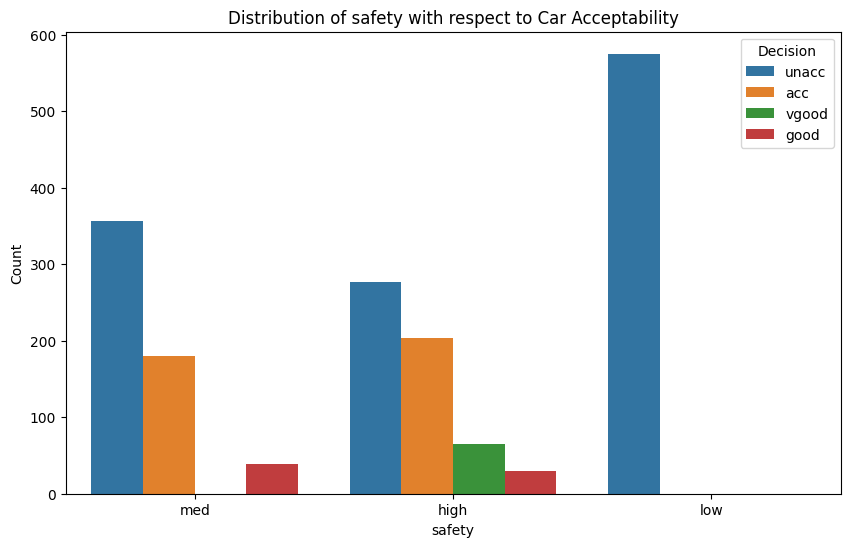

In [ ]:
# Convert the original Spark DataFrame to a Pandas DataFrame
data_pd = data.toPandas()

# List of categorical columns
categorical_columns = ["buyPrice", "maintCost", "noDoors", "noPersons", "bootLuggage", "safety"]

# Create a stacked bar chart for each feature with respect to the target variable
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, hue="decision", data=data_pd)
    plt.title(f"Distribution of {column} with respect to Car Acceptability")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.legend(title="Decision")
    plt.show()

In [ ]:
# Preprocessing
indexers = [StringIndexer(inputCol=column, outputCol=column + "_index") for column in categorical_columns]

In [ ]:
# Add the indexer for the target variable column
decision_indexer = StringIndexer(inputCol="decision", outputCol="class_index")
indexers.append(decision_indexer)

for indexer in indexers:
    data = indexer.fit(data).transform(data)

In [ ]:
# Assembling features
assembler = VectorAssembler(inputCols=[col + "_index" for col in categorical_columns], outputCol="features")
data = assembler.transform(data)

In [ ]:
# Show a sample of the transformed data with the indexed values
selected_columns = [col_name for col_name in data.columns if "_index" in col_name] + categorical_columns
sample_data = data.select(selected_columns)
sample_data.show(n=10)

+--------------+---------------+-------------+---------------+-----------------+------------+-----------+--------+---------+-------+---------+-----------+------+
|buyPrice_index|maintCost_index|noDoors_index|noPersons_index|bootLuggage_index|safety_index|class_index|buyPrice|maintCost|noDoors|noPersons|bootLuggage|safety|
+--------------+---------------+-------------+---------------+-----------------+------------+-----------+--------+---------+-------+---------+-----------+------+
|           3.0|            3.0|          3.0|            2.0|              2.0|         1.0|        0.0|   vhigh|    vhigh|      2|        2|      small|   med|
|           3.0|            3.0|          3.0|            2.0|              2.0|         0.0|        0.0|   vhigh|    vhigh|      2|        2|      small|  high|
|           3.0|            3.0|          3.0|            2.0|              1.0|         2.0|        0.0|   vhigh|    vhigh|      2|        2|        med|   low|
|           3.0|            

In [ ]:
# Splitting data
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Model 1: Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="class_index", featuresCol="features", maxDepth=5, impurity="gini", seed=42)
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

# Model 2: Random Forest Classifier
rf = RandomForestClassifier(labelCol="class_index", featuresCol="features", numTrees=100, maxDepth=5, impurity="gini", seed=42)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

In [ ]:
# Get the fitted decision_indexer from the data
fitted_decision_indexer = data.schema["class_index"].metadata["ml_attr"]["vals"]

In [ ]:
# Create IndexToString transformers
label_converter = IndexToString(inputCol="class_index", outputCol="actualLabel", labels=fitted_decision_indexer)
pred_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=fitted_decision_indexer)

In [ ]:
# Apply transformers to both the Decision Tree and Random Forest predictions
dt_predictions = label_converter.transform(dt_predictions)
dt_predictions = pred_converter.transform(dt_predictions)

rf_predictions = label_converter.transform(rf_predictions)
rf_predictions = pred_converter.transform(rf_predictions)

In [ ]:
# Evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="class_index", predictionCol="prediction", metricName="accuracy")
dt_accuracy = evaluator.evaluate(dt_predictions)
rf_accuracy = evaluator.evaluate(rf_predictions)

evaluator.setMetricName("f1")
dt_f1 = evaluator.evaluate(dt_predictions)
rf_f1 = evaluator.evaluate(rf_predictions)

print(f"Decision Tree: Accuracy = {dt_accuracy:.2f}, F1 score = {dt_f1:.2f}")
print(f"Random Forest: Accuracy = {rf_accuracy:.2f}, F1 score = {rf_f1:.2f}")

Decision Tree: Accuracy = 0.88, F1 score = 0.87
Random Forest: Accuracy = 0.90, F1 score = 0.89


In [ ]:
# Convert Spark DataFrames to Pandas DataFrames
dt_pd = dt_predictions.select("actualLabel", "predictedLabel").toPandas()
rf_pd = rf_predictions.select("actualLabel", "predictedLabel").toPandas()

# Generate classification reports
dt_report = classification_report(dt_pd["actualLabel"], dt_pd["predictedLabel"],zero_division=1)
rf_report = classification_report(rf_pd["actualLabel"], rf_pd["predictedLabel"],zero_division=1)



In [ ]:
print("Decision Tree Classification Report:\n", dt_report)

Decision Tree Classification Report:
               precision    recall  f1-score   support

         acc       0.73      0.81      0.77        72
        good       1.00      0.00      0.00        11
       unacc       0.94      0.95      0.95       227
       vgood       0.71      0.86      0.77        14

    accuracy                           0.88       324
   macro avg       0.85      0.65      0.62       324
weighted avg       0.89      0.88      0.87       324



In [ ]:
print("Random Forest Classification Report:\n", rf_report)

Random Forest Classification Report:
               precision    recall  f1-score   support

         acc       0.72      0.90      0.80        72
        good       1.00      0.00      0.00        11
       unacc       0.97      0.95      0.96       227
       vgood       1.00      0.86      0.92        14

    accuracy                           0.90       324
   macro avg       0.92      0.68      0.67       324
weighted avg       0.92      0.90      0.89       324



In [ ]:
# Feature Importance
importances = rf_model.featureImportances
column_importances = list(zip([col + "_index" for col in categorical_columns], importances))
sorted_importances = sorted(column_importances, key=lambda x: x[1], reverse=True)

for col, importance in sorted_importances:
    print(f"{col}: {importance:.2f}")

safety_index: 0.38
noPersons_index: 0.34
buyPrice_index: 0.13
maintCost_index: 0.11
bootLuggage_index: 0.04
noDoors_index: 0.00


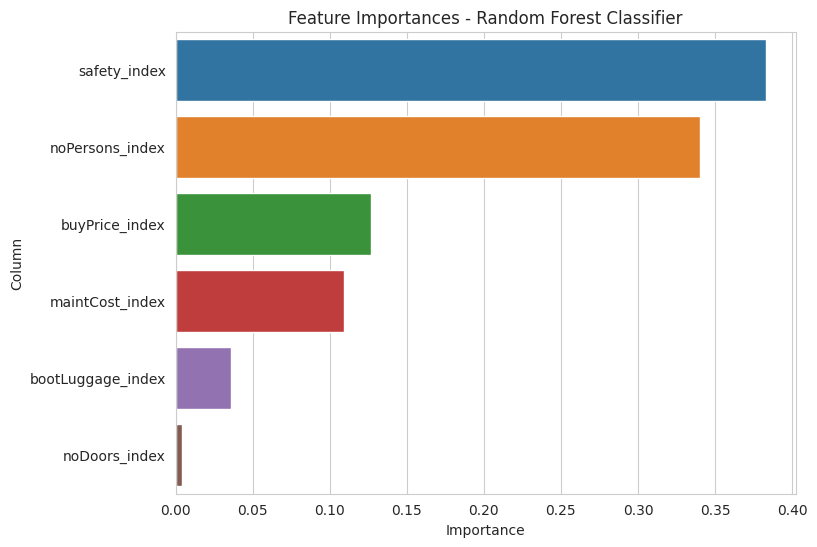

In [ ]:
# Plot Feature Importances
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x="importance", y="column", data=pd.DataFrame(sorted_importances, columns=["column", "importance"]))
plt.title("Feature Importances - Random Forest Classifier")
plt.xlabel("Importance")
plt.ylabel("Column")
plt.show()

In [ ]:
# Calculate confusion matrices
dt_cm = confusion_matrix(dt_pd["actualLabel"], dt_pd["predictedLabel"])
rf_cm = confusion_matrix(rf_pd["actualLabel"], rf_pd["predictedLabel"])

# Get the unique target labels
unique_labels = sorted(data.select("decision").distinct().rdd.map(lambda row: row[0]).collect())



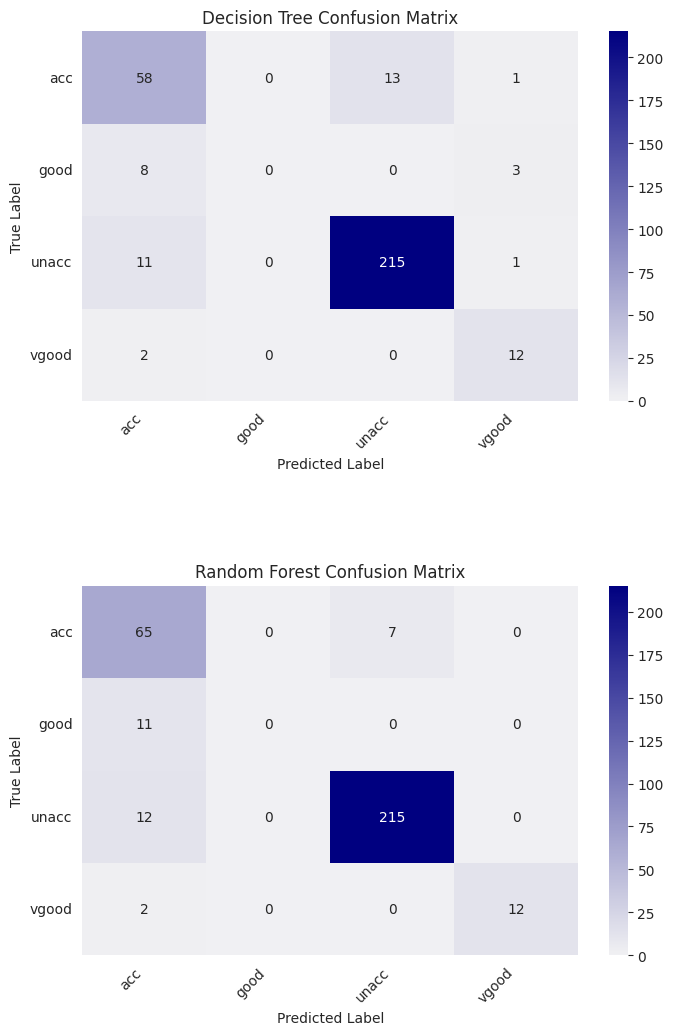

In [ ]:

# Set the color map for the heatmaps
cmap = sns.light_palette("navy", as_cmap=True)

# Create a figure and define the size
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

# Add padding between subplots
fig.subplots_adjust(hspace=0.5)

# Plot the Decision Tree confusion matrix
sns.heatmap(dt_cm, annot=True, fmt="d", ax=axes[0], cmap=cmap, cbar=True, xticklabels=unique_labels, yticklabels=unique_labels)
axes[0].set_title("Decision Tree Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0, ha='right')

# Plot the Random Forest confusion matrix
sns.heatmap(rf_cm, annot=True, fmt="d", ax=axes[1], cmap=cmap, cbar=True, xticklabels=unique_labels, yticklabels=unique_labels)
axes[1].set_title("Random Forest Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0, ha='right')

# Show the plots
plt.show()

